# Algorithms for Big Data - Exercise 11
This lecture is focused on Generative Adversarial Networks for image generation.

A generative adversarial network (GAN) is deployed to create unique images of handwritten digits. The generated images look like they're taken from the dataset (that is the purpose), but they are generated from scratch (actually, from noise) and are all unique.

You can download the dataset from this course on [Github](https://github.com/rasvob/2020-21-ARD/tree/master/datasets)

[Open in Google colab](https://colab.research.google.com/github/rasvob/2020-21-ARD/blob/master/abd_11.ipynb)
[Download from Github](https://github.com/rasvob/2020-21-ARD/blob/master/abd_11.ipynb)

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import matplotlib.pyplot as plt # plotting
import matplotlib.image as mpimg # images
import numpy as np #numpy
import seaborn as sns
import tensorflow as tf
# import tensorflow.compat.v2 as tf #use tensorflow v2 as a main 
import tensorflow.keras as keras # required for high level applications
from sklearn.model_selection import train_test_split # split for validation sets
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import normalize # normalization of the matrix
import scipy
import pandas as pd

tf.version.VERSION

'2.3.0'

In [2]:
import requests
from typing import List, Tuple

In [3]:
def show_history(history):
    plt.figure()
    for key in history.history.keys():
        plt.plot(history.epoch, history.history[key], label=key)
    plt.legend()
    plt.tight_layout()

# What is GAN (Generative Adversarial Networks)?

GAN is almost always explained like the case of a counterfeiter (Generative) and the police (Discriminator). Initially, the counterfeiter will show the police a fake money. The police says it is fake. The police gives feedback to the counterfeiter why the money is fake. The counterfeiter attempts to make a new fake money based on the feedback it received. The police says the money is still fake and offers a new set of feedback. The counterfeiter attempts to make a new fake money based on the latest feedback. The cycle continues indefinitely until the police is fooled by the fake money because it looks real.

![model](https://github.com/rasvob/2020-21-ARD/raw/master/images/gan01.png)

## We will work with MNIST data in this lecture again

We will rescale the data into the [0,1] interval for easier training of the network.

In [10]:
# mnist is the basic dataset with handwritten digits
dataset = tf.keras.datasets.mnist

# data from any dataset are loaded using the load_Data function
(train_x, train_y), (test_x, test_y) = dataset.load_data()

train_x, test_x = train_x/255.0, test_x/255.0

train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=0.2, random_state=42)

# the data are in the form of 28x28 pixes with values 0-255.
print('Train data shape: ', train_x.shape, train_y.shape)
print('Validation data shape: ', valid_x.shape, valid_y.shape)
print('Test data shape:  ', test_x.shape, test_y.shape)

class_names = [str(x) for x in range(10)]

Train data shape:  (48000, 28, 28) (48000,)
Validation data shape:  (12000, 28, 28) (12000,)
Test data shape:   (10000, 28, 28) (10000,)


#### Show first 25 images from the dataset

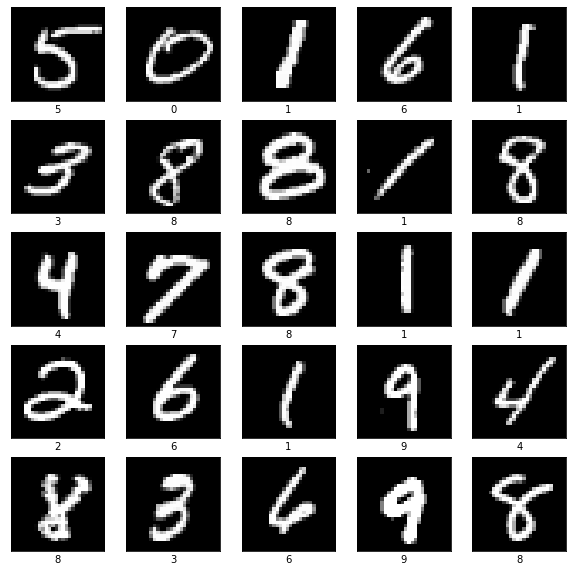

In [11]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_x[i], cmap=plt.cm.gray)
    plt.xlabel(class_names[train_y[i]])
plt.show()

# GAN has two main parts - Discriminator and Generator

## Discriminator
A discriminator that tells how real an image is, is basically a deep Convolutional Neural Network (CNN). 

For MNIST Dataset, the input is an image (28 pixel x 28 pixel x 1 channel). The sigmoid output is a scalar value of the probability of how real the image is (0.0 is certainly fake, 1.0 is certainly real, anything in between is a gray area). 

The difference from a typical CNN is the absence of max-pooling in between layers. Instead, a strided convolution is used for downsampling. The activation function used in each CNN layer is a leaky ReLU. A dropout between 0.4 and 0.7 between layers prevent over fitting and memorization, but it is an optional feature.

![disc](https://github.com/rasvob/2020-21-ARD/raw/master/images/gan02.png)

## Generator
The generator synthesizes fake images. The fake image is generated from a N-dimensional noise (uniform distribution between -1.0 to 1.0, gaussian noise etc.) using the inverse of convolution, called transposed convolution. 

The activation function after each layer is a LeakyReLU. The output of the sigmoid/tanh at the last layer produces the fake image.

![](https://github.com/rasvob/2020-21-ARD/raw/master/images/gan03.png)

## Adversarial Model
The adversarial model is just the generator-discriminator stacked together as shown in the figure below.

![](https://raw.githubusercontent.com/rasvob/2020-21-ARD/master/images/gan04.png)

# Training

![](https://github.com/rasvob/2020-21-ARD/raw/master/images/gan05.png)

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights.best.hdf5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

In [ ]:
batch_size = 32
epochs = 100
history = model.fit(train_x, train_y, validation_split=0.2, callbacks=[model_checkpoint_callback], epochs=epochs, batch_size=batch_size)

show_history(history)

In [ ]:
model.load_weights("weights.best.hdf5")

In [ ]:
test_loss, test_acc = model.evaluate(test_x, test_y)

In [ ]:
model.evaluate(train_x, train_y)